In [1]:
%matplotlib inline
import cv2
import json
import os
import matplotlib.pyplot
import pathlib
import random
import re

from PIL import Image

In [2]:
eval = "coco"
path_coco_file = "coco_results.json"
path_result = "results/genero"
path_img = "ok"
path_bounding_box_true = "data/genero/bounding_box_true"
color_bounding_box_true = (0, 0, 0)
font_text = cv2.FONT_HERSHEY_PLAIN
classes = ["manekia", "ottonia", "peperomia", "piper", "pothomorphe"]
# classes = ["especime", "barradeescala", "carimbo", "paletadecor", "rotulo", "envelope", "codbarra"]
colors = {}

In [3]:
for c in classes:
    r = random.randint(0, 255)
    g = random.randint(0, 255)
    b = random.randint(0, 255)
    colors[c] = (r, g, b)
colors

{'manekia': (150, 165, 235),
 'ottonia': (60, 189, 102),
 'peperomia': (131, 23, 188),
 'piper': (137, 136, 217),
 'pothomorphe': (9, 170, 16)}

In [4]:
def coco_to_yolo(x1, y1, w, h, image_w, image_h):
    return [((2*x1 + w)/(2*image_w)), ((2*y1 + h)/(2*image_h)), w/image_w, h/image_h]

def pascal_voc_to_yolo(x1, y1, x2, y2, image_w, image_h):
    return [((x2 + x1)/(2*image_w)), ((y2 + y1)/(2*image_h)), (x2 - x1)/image_w, (y2 - y1)/image_h]

In [5]:
def draw_bounding_box(colors, image, pred_per_image, threshold=0):
    for p in pred_per_image:
        filename, confidence, x_min, y_min, width, height, label = re.split("[ ]", p)

        confidence = float(confidence)
        if confidence >= threshold:
            x = float(x_min)
            y = float(y_min)
            w = float(width)
            h = float(height)

            dh, dw, _ = image.shape

            x_center, y_center, width, height = coco_to_yolo(x, y, w, h, dw, dh)
            print(x_center, y_center, width, height, label)

            x1 = int((x_center - width / 2) * dw)
            x2 = int((x_center + width / 2) * dw)
            y1 = int((y_center - height / 2) * dh)
            y2 = int((y_center + height / 2) * dh)

            text = f"{label}+{confidence}"
            image = cv2.rectangle(image, (x1, y1), (x2, y2), colors[label], 10)
            image = cv2.putText(image, text, (x1, y1 - 10), cv2.FONT_HERSHEY_PLAIN, 3, color_bounding_box_true, 4)
            image = draw_bounding_box_true(dh, dw, filename, image, label)

            path_outfile = os.path.join("out", "vocc")
            save_image(filename, image, path_outfile, threshold)


def draw_bounding_box_true(dh, dw, filename, image, label):
    with open(os.path.join(path_bounding_box_true, f"{filename}.txt")) as file:
        lines = file.readlines()
        file.close()
    for l in lines:
        id, x_center, y_center, width, height = re.split("[ ]", l)
        if int(id) != 0:
            print(x_center, y_center, width, height, label)

            x1 = int((float(x_center) - float(width) / 2) * dw)
            x2 = int((float(x_center) + float(width) / 2) * dw)
            y1 = int((float(y_center) - float(height) / 2) * dh)
            y2 = int((float(y_center) + float(height) / 2) * dh)

            image = cv2.rectangle(image, (x1, y1), (x2, y2), color_bounding_box_true, 10)
    return image


def save_image(filename, image, path_outfile, threshold):
    pathlib.Path(path_outfile).mkdir(parents=True, exist_ok=True)
    if threshold != 0:
        path_outfile = os.path.join(path_outfile, f"{filename}_bb_threshold.png")
    else:
        path_outfile = os.path.join(path_outfile, f"{filename}_bb.png")
    cv2.imwrite(path_outfile, image)

In [6]:
def read_vocc_file():
    list_results = list([result for result in pathlib.Path(path_result).rglob("*.txt")])
    print(len(list_results))

    predictions = list([])
    for result in list_results:
    # if not "especime" in str(result.stem):
        try:
            with open(result) as file:
                lines = file.readlines()
                file.close()
        except:
            raise FileNotFoundError(f"file {result} not found")

        _, _, _, label = re.split("[_]", str(result.stem))

        predictions_per_file = list()
        for l in lines:
            predictions_per_file.append(l.replace("\n", "") + f" {label.lower()}")

        predictions = predictions + predictions_per_file

    return predictions

In [7]:
list_imgs = sorted(list([img for img in pathlib.Path(path_img).rglob("*")]))
list_bounding_box_true = sorted(list([img for img in pathlib.Path(path_bounding_box_true).rglob("*")]))

len(list_imgs), len(list_bounding_box_true)

(45, 225)

In [8]:
def read_coco_file(threshold=0):
    try:
        with open(path_coco_file) as file:
            data = json.load(file)
            file.close()
    except:
        raise FileNotFoundError(f"file {path_coco_file} not found")

    for file in list_imgs:
        # filename should be only numbers
        pred_per_image = list([d for d in data if d["image_id"] == int(file.stem)])
        image = cv2.imread(str(file.resolve()))
        for p in pred_per_image:
            confidence = p["score"]

            if confidence >= threshold:
                label = classes[p["category_id"] - 1]
                x_min = p["bbox"][0]
                y_min = p["bbox"][1]
                x_max = p["bbox"][2]
                y_max = p["bbox"][3]

                dw, dh, _ = image.shape

                x_center, y_center, width, height = pascal_voc_to_yolo(x_min, y_min, x_max, y_max, dw, dh)
                x1 = int((x_center - width / 2) * dw)
                x2 = int((x_center + width / 2) * dw)
                y1 = int((y_center - height / 2) * dh)
                y2 = int((y_center + height / 2) * dh)

                text = f"{label}+{confidence}"
                image = cv2.rectangle(image, (x1, y1), (x2, y2), colors[label], 10)
                image = cv2.putText(image, text, (x1, y1 - 10), font_text, 3, color_bounding_box_true, 4)
                image = draw_bounding_box_true(dh, dw, file.stem, image, label)

        path_outfile = os.path.join("out", "coco")
        save_image(file.stem, image, path_outfile, threshold)

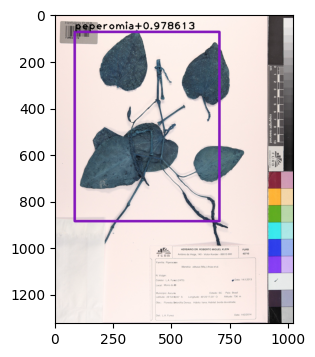

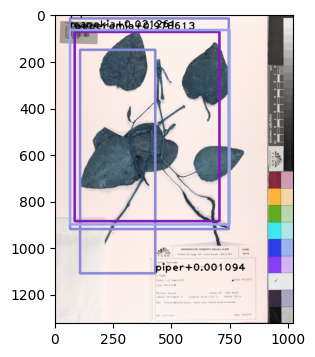

In [9]:
if eval == "coco":
    read_coco_file(threshold=0.8)
    read_coco_file(threshold=0)
elif eval == "vocc":
    predictions = read_vocc_file()
    for img in list_imgs:
        pred_per_image = list(filter(lambda x: str(img.stem) in x, predictions))
        print(img.stem, len(pred_per_image))
        image = cv2.imread(str(img))
        image_threshold = cv2.imread(str(img))

        draw_bounding_box(colors, image, pred_per_image)
        draw_bounding_box(colors, image_threshold, pred_per_image, threshold=0.8)
else:
    raise ValueError (f"value {eval} not recognized")